In [21]:
"""
import things required
"""
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [22]:
"""
Helper functions to load data
"""
def load_mnist_dataset(dataset, path):
    """
    returns samples and lables specified by path and dataset params

    loop through each label and append image to X and label to y
    """
    labels = os.listdir(os.path.join(path, dataset))

    X = []
    y = []
    
    for label in labels:
        image_counter = 0
        for file in os.listdir(os.path.join(path, dataset, label)):
            image = cv2.imread(os.path.join(path, dataset, label, file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label)

    return np.array(X), np.array(y).astype('uint8')

def create_data_mnist(path):
    """
    returns train X, y and test X and y
    """
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)
    
    return X, y, X_test, y_test

In [3]:
"""
get train and test data 
scale data to be in range of -1 to 1 i.e. centered around 0
"""
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

# Scale features
X = (X.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

# print(X.min(), X.max())
# print(X.shape)

In [4]:
print(X.shape)
print(y.shape)

(60000, 28, 28)
(60000,)


In [18]:
"""
pixel size - 28 x 28 - 784 features
images are reshaped to be next to each other
"""
# Reshape to vectors
X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X.shape[1]

784

[0 1 2 3 4 5 6 7 8 9]


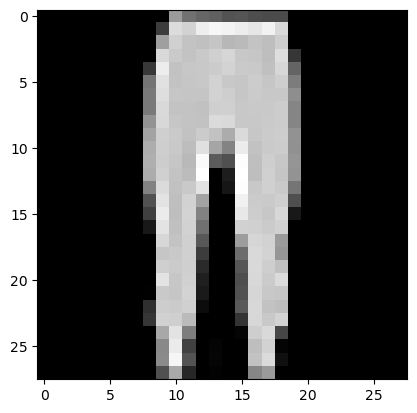

In [15]:
"""
shuffle the keys to remove biase that might be caused towards one label
"""
keys = np.array(range(X.shape[0]))
print(keys[:10])
np.random.shuffle(keys)
X = X[keys]
y = y[keys]
plt.imshow((X[4].reshape(28, 28)), cmap='gray')
plt.show()

In [7]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, 
                 weight_regularizer_l1=0, weight_regularizer_l2=0, 
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        """
        n_inputs represents the no of features
        n_neurons represents the no of neurons we want in this particular layer

        weights are inputs x no of neurons - helps avoid transpose operation in dot product
        weights range between -1 to +1 so tht they are close to each other and NN doesn't explode
        
        biases is set to zero initially and if we encounter error where the entore output of
        NN is zero we cqan intialize it to some value to avoid dead ANN
        
        rest four parameters referes to lambda that will be used for
        L1 and L2 regularization
        """
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
            self.weights
        
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
            self.biases
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [8]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        # input negative - gradient zero
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs

        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
    
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [9]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        mean_loss = np.mean(sample_losses)
        return mean_loss
    
    def regularization_loss(self, layer):

        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        # account for zero values -log(0) = inf and then remove biasis caused by its intro
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            # y_true is in the form of [1, 0, 1, 1 ....]
            correct_confidences = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            # y_true is in the form of matric [[0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0]....]
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        negative_log_likelihood = - np.log(correct_confidences)

        return negative_log_likelihood
    
    def backward(self, dvalues, y_true):
        
        samples = len(dvalues)
        labels = len(dvalues[0])
        # convert to hot vector if not
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()   

    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [10]:
class Optimizer_SGD:
    """
    Vanilla option - SGD
    Momentum option - if specified else default 0
    """
    def __init__(self, learning_rate=1.0, decay=0, momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If we use momentum
        if self.momentum:

            # create momentum array if not present along with biases
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        # Update weights and biases using either vanilla or momentum update
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

In [11]:
"""
Features = 784
Samples = 60,000
class labels = 10 (0 - 9)

2 hidden layes - ReLU    - 128 neurons each
1 output layer - Softmax - 10 output neurons

Optimizer - SGD with momentum (0.5)
learning rate decay - 0.01
l2 regularization - lambda - 5e-4 (0.0005)
"""

dense1 = Layer_Dense(X.shape[1], 128, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(128, 128)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(128, 10)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(decay=0.01, momentum=0.5)

accuracies = []
losses = []
learning_rate = []

In [12]:
for epoch in range(1100):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    data_loss = loss_activation.forward(dense3.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) + \
        loss_activation.loss.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)


    if not epoch % 10:
        accuracies.append(accuracy)
        losses.append(loss)
        learning_rate.append(optimizer.current_learning_rate)
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' + f'lr: {optimizer.current_learning_rate}'
             + f'Rr: {regularization_loss}')

    loss_activation.backward(loss_activation.output, y)
    dense3.backward(loss_activation.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.112, loss: 2.308, lr: 1.0Rr: 0.00503451968865524
epoch: 10, acc: 0.100, loss: 10.680, lr: 0.9174311926605504Rr: 0.00838227200825124
epoch: 20, acc: 0.238, loss: 2.456, lr: 0.8403361344537815Rr: 0.4002204596130479
epoch: 30, acc: 0.335, loss: 2.184, lr: 0.7751937984496123Rr: 0.406407055266603
epoch: 40, acc: 0.313, loss: 2.323, lr: 0.7194244604316546Rr: 0.41817819724849087
epoch: 50, acc: 0.185, loss: 2.690, lr: 0.6711409395973155Rr: 0.42146232069142076
epoch: 60, acc: 0.169, loss: 2.628, lr: 0.628930817610063Rr: 0.4136935871644017
epoch: 70, acc: 0.298, loss: 2.170, lr: 0.591715976331361Rr: 0.4059028981217895
epoch: 80, acc: 0.341, loss: 2.039, lr: 0.5586592178770949Rr: 0.3975730039535512
epoch: 90, acc: 0.203, loss: 2.439, lr: 0.5291005291005291Rr: 0.3899865106487447
epoch: 100, acc: 0.174, loss: 2.643, lr: 0.5025125628140703Rr: 0.3868441508671544
epoch: 110, acc: 0.216, loss: 2.289, lr: 0.47846889952153115Rr: 0.3797515158791232
epoch: 120, acc: 0.213, loss: 2.312, lr

epoch: 990, acc: 0.841, loss: 0.662, lr: 0.09182736455463728Rr: 0.21264512590920423
epoch: 1000, acc: 0.842, loss: 0.660, lr: 0.09099181073703366Rr: 0.21190822497789233
epoch: 1010, acc: 0.842, loss: 0.658, lr: 0.09017132551848513Rr: 0.21117964117771595
epoch: 1020, acc: 0.842, loss: 0.657, lr: 0.08936550491510277Rr: 0.21046016692546368
epoch: 1030, acc: 0.842, loss: 0.656, lr: 0.08857395925597873Rr: 0.20974990373548155
epoch: 1040, acc: 0.841, loss: 0.655, lr: 0.08779631255487269Rr: 0.20904912304126
epoch: 1050, acc: 0.842, loss: 0.653, lr: 0.08703220191470844Rr: 0.20835730436982514
epoch: 1060, acc: 0.843, loss: 0.651, lr: 0.08628127696289906Rr: 0.20767388518449204
epoch: 1070, acc: 0.843, loss: 0.650, lr: 0.0855431993156544Rr: 0.20699831315887868
epoch: 1080, acc: 0.844, loss: 0.648, lr: 0.08481764206955046Rr: 0.2063304252037452
epoch: 1090, acc: 0.844, loss: 0.646, lr: 0.08410428931875526Rr: 0.20567010121676432


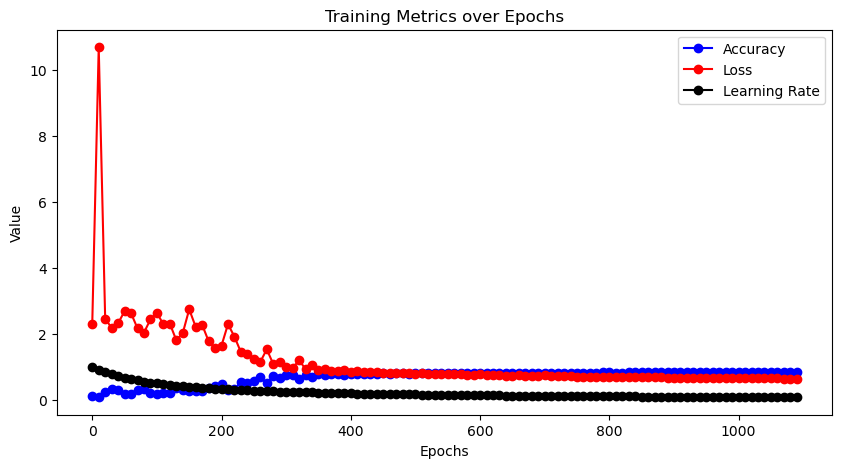

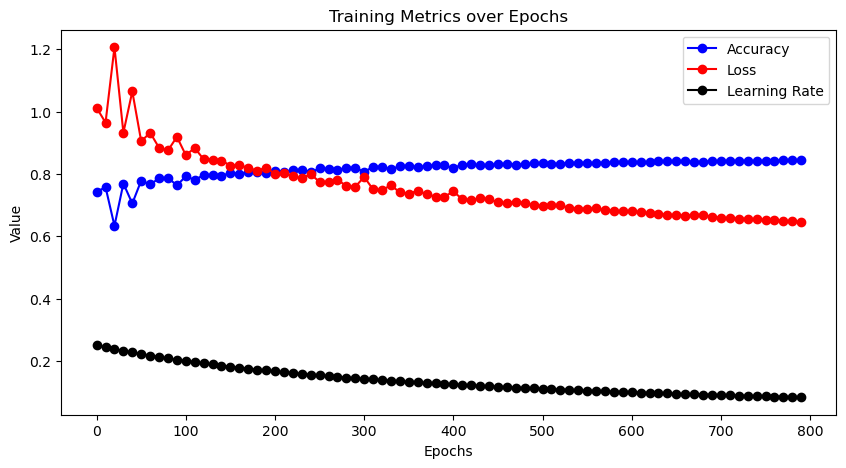

In [20]:
epochs = range(0, 1100, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, label='Accuracy', marker='o', color="blue")
plt.plot(epochs, losses, label='Loss', marker='o', color='red')
plt.plot(epochs, learning_rate, label='Learning Rate', marker='o', color='black')
plt.title('Training Metrics over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

epochs = range(0, 800, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies[30:], label='Accuracy', marker='o', color="blue")
plt.plot(epochs, losses[30:], label='Loss', marker='o', color='red')
plt.plot(epochs, learning_rate[30:], label='Learning Rate', marker='o', color='black')
plt.title('Training Metrics over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

In [14]:
# Validate the model

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
data_loss = loss_activation.forward(dense3.output, y_test)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 0.825, loss: 0.645
